# CONVERSATION ANALYSIS WITH PANDAS, NLTK, SPACY, SENSE2VEC

In [1]:
# UNCOMMENT TO INSTALL REQUIREMENTS.TXT
# import sys
#!{sys.executable} -m pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.svm import LinearSVC
from collections import Counter
from copy import deepcopy
from wordcloud import WordCloud,STOPWORDS
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.naive_bayes import MultinomialNB
import spacy
nlp = spacy.load("en_core_web_md")
import nltk
from nltk.wsd import lesk
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
nltk.download('wordnet')
nltk.download('popular')
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anedilko\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\anedilko\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\anedilko\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\anedilko\AppData\Roaming\nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\anedilko\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C

# PART 1. SIMPLE EDA

In [3]:
# LOAD DATA
with open('dataset-1/dialogues_text.txt', encoding='utf-8') as text, open('dataset-1/dialogues_topic.txt', encoding='utf-8') as topic,\
     open('dataset-1/dialogues_act.txt', encoding='utf-8') as act, open('dataset-1/dialogues_emotion.txt', encoding='utf-8') as emo:
    data = list(zip(text.readlines(), topic.readlines(), act.readlines(), emo.readlines()))
    
# create df    
df = pd.DataFrame(data, columns =['text', 'topic', 'act', 'emotion'])

# transform data for more convinient further use
df['topic'] = df['topic'].apply(lambda x: int(x.strip()))        # topic - one in each row
df['act'] = df['act'].apply(lambda x: x.split())                 # list of speech act labels
df['emotion'] = df['emotion'].apply(lambda x: x.split())         # list of emotion labels
#df['text'] = df['text'].apply(lambda x: x.split('__eou__'))     # list of utterances (for speech act & emotion classifiers)
df.head()

text  topic              act  \
0  The kitchen stinks . __eou__ I'll throw out th...      1           [3, 4]   
1  So Dick , how about getting some coffee for to...      1  [3, 4, 3, 1, 1]   
2  Are things still going badly with your housegu...      1     [2, 1, 3, 4]   
3  Would you mind waiting a while ? __eou__ Well ...      1     [3, 2, 1, 1]   
4  Are you going to the annual party ? I can give...      1        [3, 4, 1]   

           emotion  
0           [2, 0]  
1  [4, 2, 0, 1, 0]  
2     [0, 1, 0, 0]  
3     [0, 0, 0, 4]  
4        [0, 4, 4]

In [4]:
# CHECK IF THERE ARE DUPLICATE CONVERSATIONS
def count_topics(convs):       
    multi = []
    for conv in convs:
        tops = df[df['text'] == conv]['topic'].tolist()
        if len(set(tops)) != 1:   
            multi.append(conv)
            print(tops)
    return multi
        
repeated = [item for item in set(df['text'].tolist()) if df['text'].tolist().count(item) > 1]
repeated_multilabel = count_topics(repeated)
repeated_oneLabel = [conv for conv in repeated if conv not in repeated_multilabel]
print('Repeated conversations:', len(repeated))
print('Repeated conversations w/same topic:', len(repeated_oneLabel))
print('Repeated conversations w/different topics (multiple labels):', len(repeated_multilabel))

[4, 5]
[4, 5]
[1, 5]
[1, 8]
[4, 5]
[4, 5]
[1, 2, 5]
[1, 6]
[1, 9]
[1, 6]
[4, 5]
[4, 5]
[1, 5, 5]
[5, 8]
[4, 8]
[1, 5]
[5, 8]
[5, 8]
[1, 5]
[2, 5]
[4, 8]
[5, 6]
[4, 5]
[1, 5]
[2, 4]
[4, 5]
[1, 5]
[5, 8]
[1, 4]
[1, 5]
[1, 5]
[4, 5]
[4, 5]
[5, 8]
[5, 8]
[4, 5]
[5, 8]
[4, 5]
[1, 5]
[4, 5]
[4, 5]
[1, 5]
[4, 8]
[1, 9]
[3, 5]
[5, 8]
[1, 7]
[1, 5]
[1, 5]
[4, 5]
[1, 1, 5]
[4, 5]
[1, 4]
[1, 5]
[1, 5]
[5, 8]
[1, 5]
[8, 10]
[4, 5]
[1, 9]
[1, 1, 5]
[1, 4]
[1, 5]
[5, 8]
[1, 5]
[5, 8]
[1, 5]
[1, 4]
[1, 5]
[4, 5]
[4, 5]
[1, 2]
[4, 5]
[1, 4]
[1, 5]
[1, 4]
[1, 6]
[1, 4]
[4, 8, 8]
[2, 5]
[4, 5]
[4, 5, 5]
[1, 5]
[1, 5]
[1, 5]
[4, 5, 5]
[1, 5]
[1, 5]
[4, 5]
[4, 5, 5]
[1, 4, 5]
[4, 5]
[4, 8]
[3, 5]
[1, 5]
[5, 5, 8]
[4, 4, 5]
[1, 4]
[5, 8]
[4, 5]
[5, 8]
[1, 5]
[5, 8]
[5, 8]
[4, 5]
[5, 8]
[4, 5]
[3, 4]
[5, 6]
[4, 5]
[1, 5]
[5, 8]
[4, 5]
[1, 1, 5]
[1, 1, 5]
[2, 3]
[1, 8]
[4, 5]
[1, 4]
[1, 5]
[6, 8]
[1, 5]
[1, 5]
[5, 10]
[1, 2]
[4, 8]
[4, 5]
[1, 5, 5]
[5, 8]
[1, 1, 5]
[1, 5]
[2, 4]
[4, 5]
[5, 8]
[1, 8]
[5, 8]
[

In [5]:
# FOR IDENTICAL CONVERSATIONS, CHECK IF THEIR SPEECH ACT SETS ARE ALSO IDNETICAL

# get sets of speech acts for each identical conversation
list_acts = []
for conv in repeated_oneLabel:
    list_acts.append(df[df['text'] == conv]['act'].values)

# check lengths
print('Lengths of speech act sets for similar conversations:', set([len(item) for item in list_acts]))

# iterate over sets of speech acts for the same conversation to see if they are identical
num = 0    
for item in list_acts:    
    if len(item) == 2:
        if item[0] != item[1]:
            print('Different speech acts: ' + str(item[0]) + ', ' + str(item[1]))
            num += 1
    elif len(item) == 3:
        if item[0] != item[1] or item[0] != item[1] or item[0] != item[1]:
            print('Different speech acts: ' + str(item[0]) + ', ' + str(item[1]) + ', ' + str(item[2]))
            num += 1
            
# print results            
if num == 0:
    print('\nSpeech acts for identical conversations are also identical')
else:
    print('\nIdentical conversations with different speech acts:', num)
    print('Identical conversations with identical speech acts:', len(list_acts) - num)

Lengths of speech act sets for similar conversations: {2, 3}
Different speech acts: ['3', '4', '1', '1', '2', '1'], ['3', '2', '1', '1', '2', '1']
Different speech acts: ['3', '4', '1', '2', '1', '2', '3', '4', '1', '2', '1'], ['1', '1', '1', '2', '1', '2', '3', '4', '1', '2', '1']
Different speech acts: ['3', '2', '1', '2', '1', '3'], ['3', '1', '2', '2', '1', '3']
Different speech acts: ['2', '1', '1', '3', '3', '2', '3', '4'], ['2', '1', '1', '3', '4', '3', '3', '4']
Different speech acts: ['3', '2', '1', '4'], ['3', '4', '1', '1']
Different speech acts: ['3', '4', '3', '4', '3', '4'], ['3', '4', '3', '1', '3', '1']
Different speech acts: ['3', '2', '3', '4', '1', '1', '2', '1', '1'], ['3', '2', '1', '1', '1', '1', '2', '1', '1']
Different speech acts: ['3', '4', '2', '1', '1', '3'], ['2', '1', '2', '1', '1', '3']
Different speech acts: ['2', '3', '4', '2', '1', '2', '1', '3', '4', '1'], ['3', '3', '3', '2', '1', '2', '1', '3', '4', '3']
Different speech acts: ['2', '1', '2', '1', '

Different speech acts: ['1', '1', '1', '1', '1', '1'], ['1', '1', '1', '1', '3', '4']
Different speech acts: ['1', '1', '2', '1', '2', '1', '1', '1'], ['1', '1', '2', '1', '2', '1', '3', '4']
Different speech acts: ['2', '2', '1', '2', '1', '1', '2', '1', '2', '1', '1'], ['2', '2', '1', '2', '1', '3', '2', '3', '1', '3', '4']
Different speech acts: ['2', '2', '1', '2', '1'], ['2', '1', '1', '2', '1']
Different speech acts: ['1', '2', '3', '4', '1', '4', '1', '4', '2', '1', '2', '2', '3'], ['1', '2', '3', '3', '4', '3', '4', '3', '2', '3', '2', '2', '3']
Different speech acts: ['2', '1', '2', '2', '1', '2', '1', '1', '1', '1', '1', '3', '4'], ['2', '1', '2', '2', '1', '2', '3', '4', '3', '4', '1', '3', '4']
Different speech acts: ['2', '1', '2', '1', '2', '1', '2', '1', '3', '3', '4'], ['2', '1', '2', '1', '3', '4', '2', '1', '3', '3', '4']
Different speech acts: ['3', '2', '3', '3', '2', '3', '4', '3', '4'], ['3', '1', '3', '3', '2', '1', '3', '3', '1']
Different speech acts: ['1', '1'

In [6]:
# FOR IDENTICAL CONVERSATIONS, CHECK IF THEIR EMOTION SETS ARE ALSO IDNETICAL

# get sets of emotion labels for each identical conversation
list_emos = []
for conv in repeated_oneLabel:
    list_emos.append(df[df['text'] == conv]['emotion'].values)

# check lengths
print('Lengths of emotion sets for similar conversations:', set([len(item) for item in list_emos]))

# iterate over sets of emotion labels for the same conversation to see if they are identical
num = 0    
for item in list_emos:    
    if len(item) == 2:
        if item[0] != item[1]:
            print('Different emotion sets: ' + str(item[0]) + ', ' + str(item[1]))
            num += 1
    elif len(item) == 3:
        if item[0] != item[1] or item[0] != item[1] or item[0] != item[1]:
            print('Different emotion sets: ' + str(item[0]) + ', ' + str(item[1]) + ', ' + str(item[2]))
            num += 1
                        
# print results            
if num == 0:
    print('\nEmotion sets for identical conversations are also identical')
else:
    print('\nIdentical conversations with different emotion sets:', num)
    print('Identical conversations with identical emotion sets:', len(list_acts) - num)

Lengths of emotion sets for similar conversations: {2, 3}
Different emotion sets: ['0', '4', '0', '4'], ['0', '0', '0', '0']
Different emotion sets: ['4', '4', '4', '0', '0', '0', '6', '0', '0'], ['4', '4', '4', '4', '0', '0', '0', '0', '0']
Different emotion sets: ['4', '4', '0', '0', '0', '0'], ['0', '0', '0', '0', '0', '4']
Different emotion sets: ['0', '0', '0', '5', '0', '0', '0', '0', '0'], ['0', '0', '0', '5', '0', '0', '0', '6', '0']
Different emotion sets: ['4', '4', '0', '0', '4', '4', '4'], ['4', '4', '4', '0', '4', '4', '4']
Different emotion sets: ['0', '0', '0', '0'], ['0', '0', '4', '4']
Different emotion sets: ['0', '0', '0', '0', '0', '0', '4', '4', '4', '4', '4'], ['0', '0', '0', '0', '0', '0', '0', '4', '4', '4', '4']
Different emotion sets: ['0', '0', '0', '4', '4', '4', '4', '4', '4', '4', '0'], ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Different emotion sets: ['0', '0', '4', '4'], ['0', '0', '0', '0']
Different emotion sets: ['0', '4', '6', '4'], ['6

Different emotion sets: ['4', '4', '0', '4'], ['4', '4', '4', '4']
Different emotion sets: ['0', '4', '4', '4', '4', '4', '4', '4'], ['0', '4', '4', '4', '4', '0', '0', '0']
Different emotion sets: ['0', '0', '4', '0', '0', '0', '0', '0', '4', '4', '0', '0', '0'], ['0', '0', '4', '0', '0', '0', '0', '0', '4', '0', '4', '0', '0']
Different emotion sets: ['0', '5', '6', '0', '0', '0', '1', '1'], ['0', '5', '6', '0', '0', '0', '0', '1']
Different emotion sets: ['0', '0', '6', '0', '0', '0'], ['0', '0', '0', '0', '0', '0']
Different emotion sets: ['0', '0', '0', '0', '0', '5', '0', '5', '0', '5', '0', '4'], ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Different emotion sets: ['0', '0', '0', '0', '0', '0', '0', '0'], ['0', '4', '4', '0', '0', '0', '0', '0']
Different emotion sets: ['0', '0', '4', '0', '4', '4'], ['0', '0', '0', '0', '4', '4']
Different emotion sets: ['0', '0', '0', '6', '0', '0', '0', '6', '0', '0', '0'], ['0', '6', '0', '6', '0', '0', '0', '6', '0', '0', '4

**IDENTICAL CONVERSATIONS MAY HAVE DIFFERENT SPEECH ACT SETS AND/OR DIFFERENT EMOTION LABELS**.

**CONCLUSION: GET RID OF DUPLICATES SEPARATELY FOR EACH INDIVIDUAL TYPE OF CLASSIFICATIONS - TOPICS, SPEECH ACTS, EMOTION SETS**

# PART 2. GUESSING TOPICS AND SIMPLE CLASSIFICATION

## GUESS TOPICS

In [7]:
# keep only text and topics
df_topic = deepcopy(df[['text', 'topic']])
print('All conversations:', len(df_topic))

# remove complete duplicate rows (when entire rows coincide)
df_topic = df_topic.drop_duplicates(subset = ['text', 'topic'])
print('Conversation after complete duplicates are removed:', len(df_topic))

All conversations: 13118
Conversation after complete duplicates are removed: 12596


In [8]:
# IDENTICAL CONVERSATIONS W/DIFFERENT TOPIC LABELS (MULTIPLE LABELS)
dupes = df_topic[df_topic['text'].duplicated(keep=False)].sort_values(by='text')
print('Number of conversations with multiple labels: {} out of {} or {}%'.format(len(dupes['text'].unique()), len(df_topic),
                                                                     round(100*(len(dupes['text'].unique()))/len(df_topic), 2)))
dupes.head(20)

Number of conversations with multiple labels: 218 out of 12596 or 1.73%


text  topic
8106   A friend of mine has been taking an online car...      5
12027  A friend of mine has been taking an online car...      8
1886   Ah , ah , ah ... __eou__ All right , Bill.Here...      1
6977   Ah , ah , ah ... __eou__ All right , Bill.Here...      5
6671   All right . But these are black and I don ’ t ...      5
4468   All right . But these are black and I don ’ t ...      4
4333   Are you an American ? __eou__ Yeah . __eou__ W...      3
4437   Are you an American ? __eou__ Yeah . __eou__ W...      4
2324   Are you going out again ? __eou__ Yes , I'm go...      1
6892   Are you going out again ? __eou__ Yes , I'm go...      5
10427  Are you okay , man ? You don ’ t look very wel...      7
7518   Are you okay , man ? You don ’ t look very wel...      5
11752  Billy , you are late again . __eou__ I'm sorry...      8
6777   Billy , you are late again . __eou__ I'm sorry...      5
11617  Bob , did you see our supervisor ? I need him ...      8
1763   Bob , did you see our supervisor ? I need him ...      1
3306   Broadway Mall is having a big sale this weeken...      1
4953   Broadway Mall is having a big sale this weeken...      5
2357   Can I help you ? __eou__ I hope so . I'm looki...      1
3818   Can I help you ? __eou__ I hope so . I'm looki...      2

**1.73% is not a very statistically significant share of multilable conversations. Removing multilabel conversation would simplify the classification. The most underrepresented topics are 3, 7, and 9 (see figure below). Are there a lot of conversations belonging to such topics in the multilabel subset?**

In [9]:
c = Counter(dupes['topic'].tolist())
print('Topic\tCount')
for top, count in c.most_common():
    print('{}\t{}'.format(top, count))

Topic	Count
5	165
1	95
4	80
8	62
6	11
2	9
3	5
9	5
7	4
10	2


**Not a lot - removing multilable conversation. Had I decided to keep these, I would create a dataframe with conversations in the left columns, and topics as the remaining columns. Normally, if a conversation belongs to a topic, I would put 1 in the intersecting cell and 0 otherwise. Although I may be mistaken, it's not worth the effort in this case.**

In [10]:
df_topic = df_topic.drop_duplicates(subset = ['text']).reset_index(drop=True)
len(df_topic)

12376

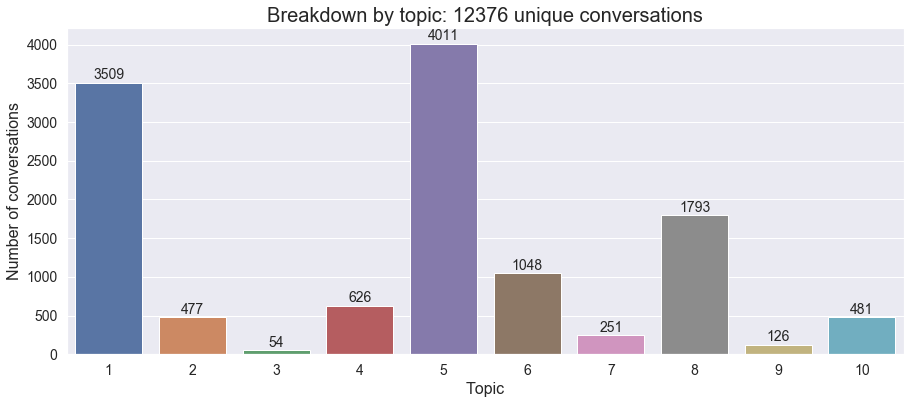

In [11]:
# PLOT CONVERSATIONS BY TOPIC
sns.set(font_scale = 1.5)
plt.figure(figsize=(15,6))

all_topics = df_topic['topic'].tolist()
unique_topics = list(set(all_topics))
counts = [all_topics.count(item) for item in unique_topics]

ax= sns.barplot(unique_topics, counts)

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False

plt.title("Breakdown by topic: {} unique conversations".format(len(all_topics)), fontsize=20)
plt.ylabel('Number of conversations', fontsize=16)
plt.xlabel('Topic', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#adding the text labels
rects = ax.patches
labels = counts
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=14)
    
plt.show()

**CONCLUSION: THIS IS AN IMBALANCED MULTICLASS DATASET: A) USE F-1 MEASURE (OR PRECISION & RECALL) INSTEAD OF ACCURACY; B) TRY TO MAKE IT MORE BALANCED BY REDUCING THE LARGEST CLASSES, E.G. BY REDUCING THE 4 LARGEST CLASSES TO 1000 CONVERSATIONS. THIS WAY I WILL HAVE 4 CLASSES WITH 1000 CONVERSATIONS, 3 WITH ~500 AND 3 UNDERREPRESENTED ONES**

In [12]:
# load a specially curated file of stopwords
with open('stop_words.txt') as f:
    stop_words = f.read().split()

stop_words.extend(stopwords.words('english'))                  # add stopwords from NLTK 
stop_words.extend(STOPWORDS)                                   # add stopwords from wordcloud

# custom stopwords by observation
stop_words.extend(['you', 'what', 'know', 'yes', 'it', 'think', 'that', 'do', 'sure', 'how', 'good', 'time', 'take', 'right',
                   'find', 'oh', 'got', 'today', 'make', 'thank', 'help', 'going','thanks','come','look', 'work', 'lot', 'new',
                   'please', 'sir', 'sorry', 'buy', 'excuse', 'try', 'back', 'two', 'way', 'give', 'tell', 'hello', 'yeah', 'bad',
                   'looks', 'idea', 'stay', 'he', 'say', 'wrong', 'night', 'day', 'made', 'hi', 'tonight', 'tonight', 'pcc',
                   'good', 'hey', 'went', 'tomorrow', 'sounds', 'believe', 'actually', 'get', 'getting', 'coming', 'problem',
                   'understand', 'yesterday', 'glad', 'ask', 'long', 'it', 'talking', 'thing', 'feel', 'done', 'better', 'in', 
                   'away', 'keep', 'agree', 'hear', 'course', 'house', 'took', '000', 'it', 'told', 'bus', 'car', 'looking',
                   'okay', 'home', 'put', 'number', 'five', 'show', 'bring', 'morning', 'mom', 'afraid', 'later', 'late'])
stop_words = list(set(stop_words))                             # exclude duplicates
stop_words = [word.strip().lower() for word in stop_words]     # remove starting and trailing spaces
print('Length of stop words:', len(stop_words))

Length of stop words: 611


In [13]:
# GET TFIDF SCORES FOR EACH WORD IN EACH CONVERSATION
# F(X) TO REMOVE STOPWORDS
def remove_sw(t):
    return ' '.join([w for w in t.split() if w not in stop_words])

df_topic['text'] = df_topic['text'].apply(lambda x: x.lower().replace(' __eou__', ''))
df_topic['text'] = df_topic['text'].apply(lambda x: remove_sw(x))
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,1), norm='l2')
X = vectorizer.fit_transform(df_topic['text'].values)
X = X.toarray()

# TFIDF MATRIX
X.shape

(12376, 18508)

In [14]:
# CREATE DATAFRAME WITH WORDS AS COLUMNS AND ROWS AS CONVERSATION INDICES
feats = vectorizer.get_feature_names()
df_new = pd.DataFrame(X, columns = feats)
print('New DF - words vs. conversation indices:', df_new.shape)
print('Conversations in new df:', df_new.index)
print('Number of words (features):', len(feats))
print('Conversations in old DF:', df_topic.index)

New DF - words vs. conversation indices: (12376, 18508)
Conversations in new df: RangeIndex(start=0, stop=12376, step=1)
Number of words (features): 18508
Conversations in old DF: RangeIndex(start=0, stop=12376, step=1)


In [15]:
# MERGE WORDS WITH THEIR SCORES
idx = df_topic[df_topic['topic'] == 1].index
topic = list(zip(df_new.loc[idx].mean().tolist(), feats))

In [16]:
sorted(topic, reverse=True)[:50]

[(0.010542307948669888, 'eat'),
 (0.0104943160308627, 'order'),
 (0.010103889285332662, 'minutes'),
 (0.009963794855204378, 'food'),
 (0.009680595268301263, 'apartment'),
 (0.009468697267125247, 'call'),
 (0.00940837768406359, 'room'),
 (0.009344603025660677, 'great'),
 (0.009237630586091825, 'dollars'),
 (0.00916994465230629, 'pay'),
 (0.009135600422790342, 'change'),
 (0.009130781675123382, 'fine'),
 (0.009018793075278812, 'nice'),
 (0.008775198826851733, 'size'),
 (0.008582761083462492, 'table'),
 (0.008347827356218154, 'yuan'),
 (0.00827844464725954, 'turn'),
 (0.007837493278435075, 'ready'),
 (0.007645488566129452, 'check'),
 (0.007629130449925865, 'stop'),
 (0.007525960589968396, 'wait'),
 (0.0072485106786127716, 'price'),
 (0.007082584140235577, 'street'),
 (0.00708031766538999, 'welcome'),
 (0.006806800368757571, 'money'),
 (0.006592731142500425, 'coffee'),
 (0.00657575558129058, 'rent'),
 (0.006464655279660851, 'drink'),
 (0.0064370699962774895, 'color'),
 (0.00642619841481437

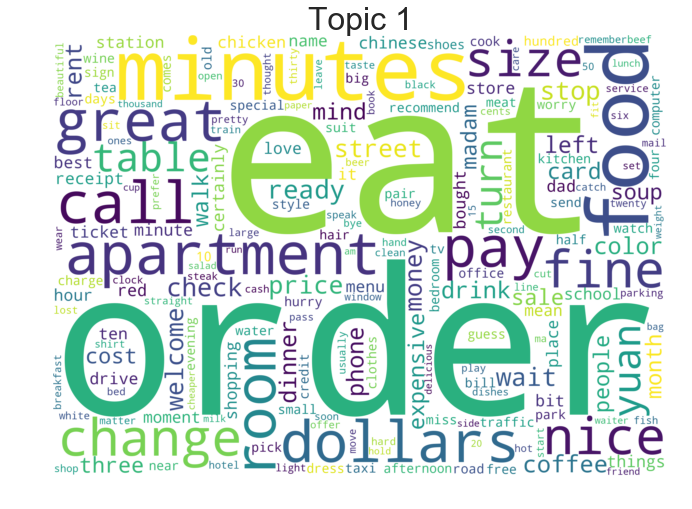

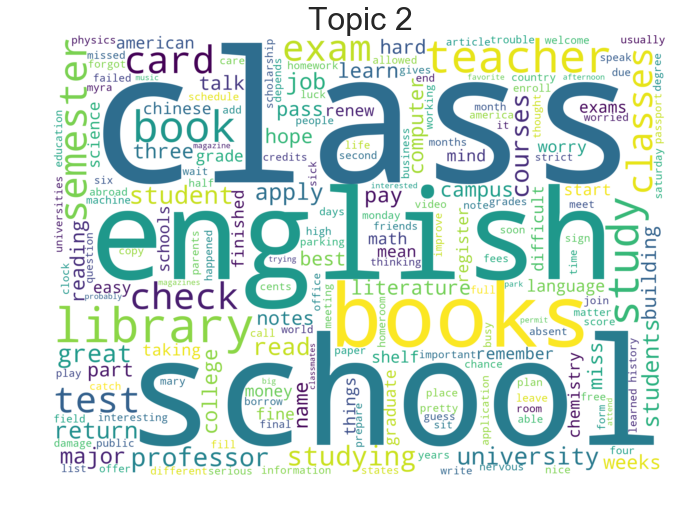

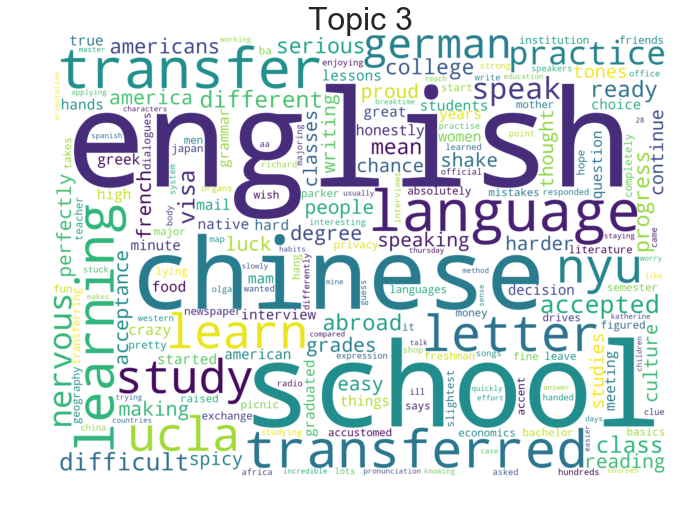

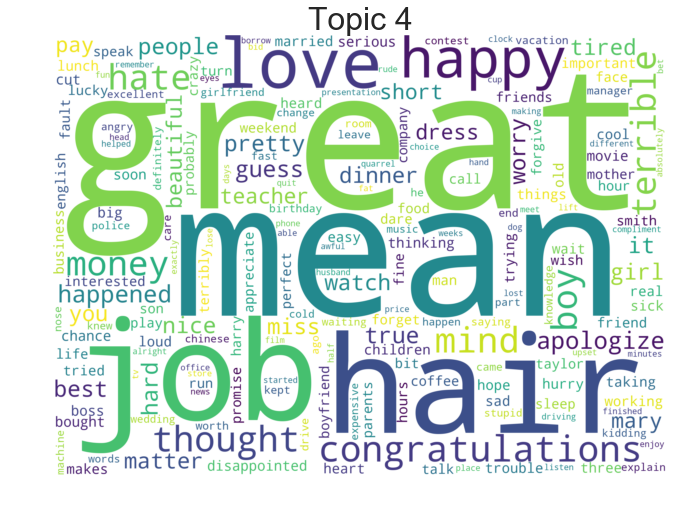

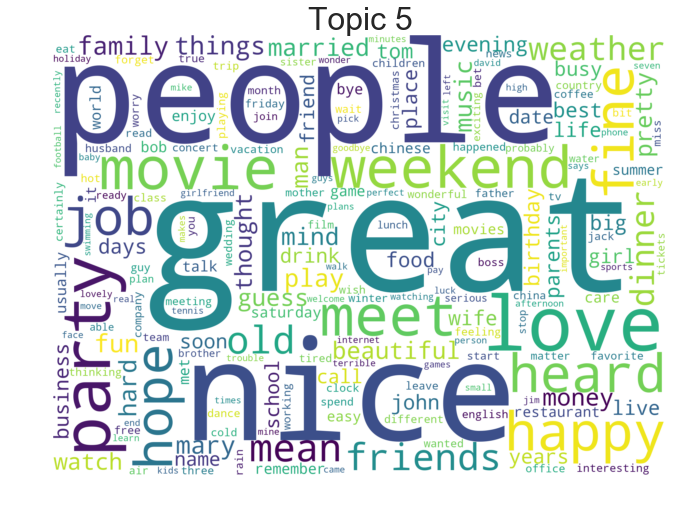

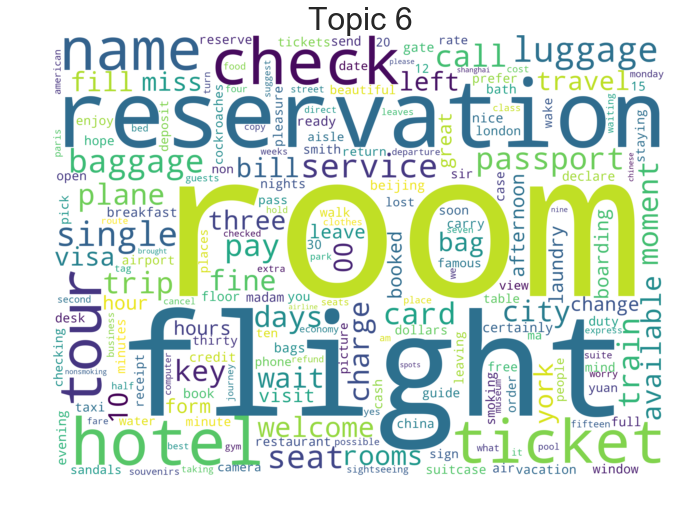

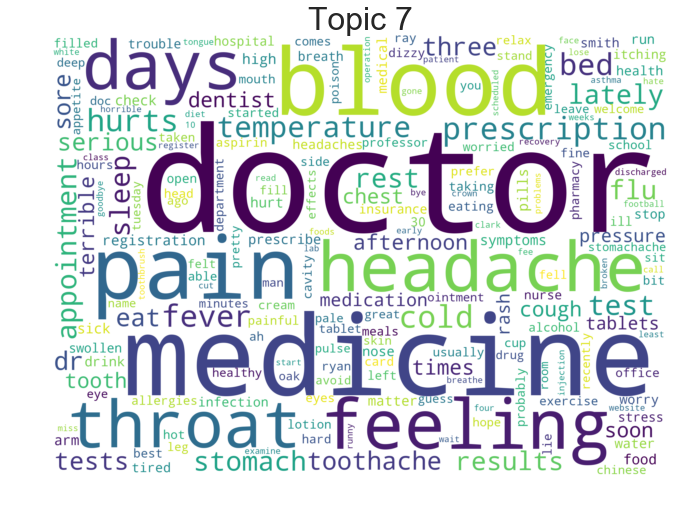

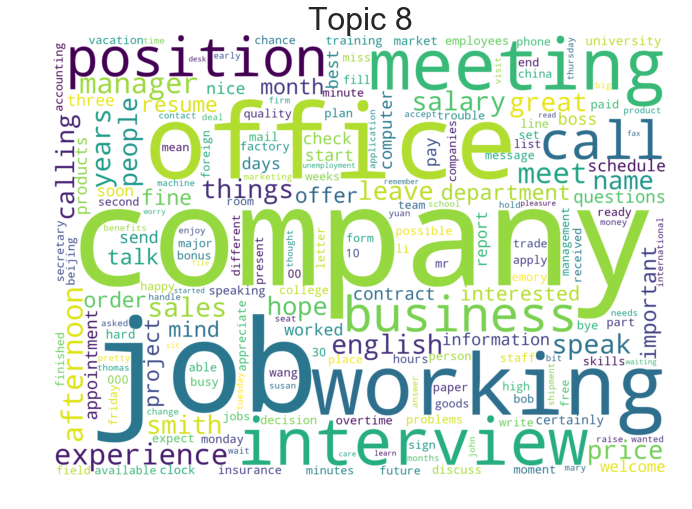

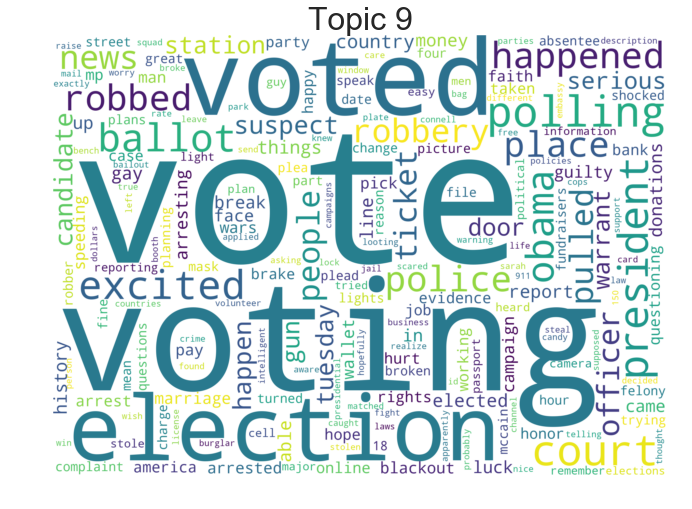

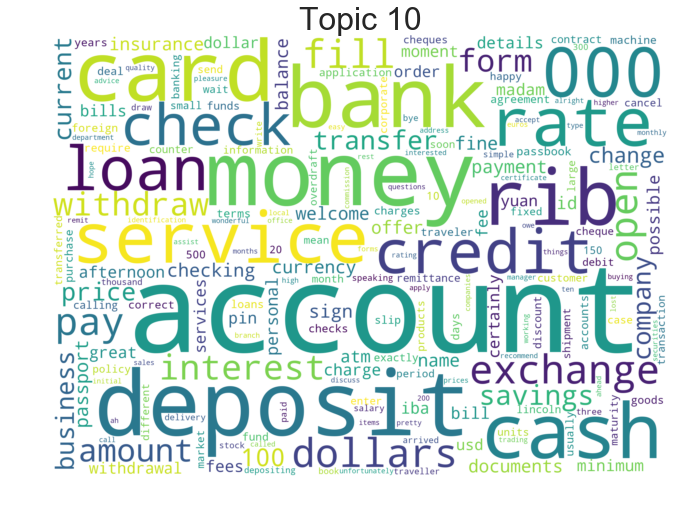

In [17]:
# Wordclouds of most popular words based on TFIDF frequencies
for topic in df_topic['topic'].unique():
    
    idx = df_topic[df_topic['topic'] == topic].index
    freq = dict()
    for rank, feat in list(zip(df_new.loc[idx].mean().tolist(), feats)):
        freq[feat] = rank
    cloud = WordCloud(    width = 2500,
                          height = 1800,
                          #max_words = 250,
                          background_color = 'white',
                          relative_scaling = 0.5,
                          normalize_plurals = True).generate_from_frequencies(freq)
    
    plt.figure(figsize=(11,11))
    plt.axis('off')
    plt.title('Topic ' + str(topic), fontsize=32)
    plt.imshow(cloud, interpolation='bilinear')

plt.show()

**If I have to guess what the topics are, it is relatively easy by looking at the words with top tf-idf scores (except for Topic 4):**
1. Food
2. School
3. Study abroad
4. Miscellaneous events?
5. Entertainment
6. Travel
7. Healthcare
8. Job search and employment
9. Elections and judicial system
10. Banking

## CLASSIFICATION WITH NAIVE BAYES

**Experiments showed that random decrease of the size of overrepresented categories 1, 5, 8 and duplicating the rows belonging to underrepresented category 3 with the purpose of balancing the number of conversations in each category does not help to improve the Naive Bayes classification performance.**

In [18]:
# F(X) TO PRINT CONFUSION MATRIX
# Modified version of https://datascience.stackexchange.com/questions/40067/confusion-matrix-three-classes-python

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
            
    plt.figure(figsize=(7,7))
    im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(im, fraction=0.046, pad=0.05)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.tight_layout()

In [19]:
# F(X) TO RUN CLASSIFICATION
def classify(df, text='text', labels='topic', ngram=2, max_df=1.0):
    
    '''
    This function runs classification and prints results.
    Input parameters:
                     df - dataframe with the entire dataset;
                     text - dataframe column containing main text;
                     labels - dataframe column containing annotation labels
                     ngram - n in the n-gram BoW model in TfidfVectorizer
                     max_df - maximum document frequency of words in TfidfVectorizer
    '''

    # RANDOMLY SELECT 20% OF EACH CATEGORY AS A TEST SET
    test_idx = pd.Index([])
    for topic in df[labels].unique():
        subset = df[df[labels] == topic]
        this_test_idx = subset.sample(frac=0.2).index
        test_idx = test_idx.union(this_test_idx)
    print('Share of test set:', round(len(test_idx) / len(df), 5))

    # GET TRAIN AND TEST SETS
    test_set = df.loc[test_idx]
    train_set = df.loc[df.index.difference(test_idx)]
    print('Train set:', train_set.shape)
    print('Test set:', test_set.shape)

    # SET AND FIT TFIDF VECTORIZER
    vectorizer = TfidfVectorizer(strip_accents='unicode', stop_words=stop_words, ngram_range=(1,ngram), max_df=max_df, min_df=1, norm='l2')
    train_text = train_set[text].tolist()
    test_text = test_set[text].values
    vectorizer.fit(train_text)
    vectorizer.fit(test_text)

    # TRANSFORM DATA
    x_train = vectorizer.transform(train_text)
    x_test = vectorizer.transform(test_text)

    # CREATE ONE VS. REST CLASSIFIER PIPELINE
    pipe = Pipeline([ ('clf', OneVsRestClassifier(MultinomialNB(alpha=0.15), n_jobs=-1)) ])    
    #pipe = Pipeline([ ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)) ])
    #pipe = LinearSVC(penalty='l2', loss='hinge', C=0.25, multi_class='ovr', random_state=1, max_iter=1000)
    #pipe = LogisticRegression(solver='sag')
    #pipe = MultinomialNB(alpha=0.15)    

    # GET LABELS
    y_train = train_set[labels].values
    y_test = test_set[labels].values

    # TRAIN MODEL
    pipe.fit(x_train, y_train)

    # PREDICT
    predict = pipe.predict(x_test)

    # PRINT CLASSIFICATION REPORT AND CONFUSTION MATRIX
    print('Average accuracy =', round(accuracy_score(y_test, predict), 2))
    print('Classification report:\n', classification_report(y_test, predict))

    labels = sorted(list(set(y_train)))
    cm = confusion_matrix(y_test, predict, labels=labels)
    #np.set_printoptions(precision=2)
    plt.figure()
    plot_confusion_matrix(cm, classes=labels)

Share of test set: 0.19998
Train set: (9901, 2)
Test set: (2475, 2)
Average accuracy = 0.68
Classification report:
               precision    recall  f1-score   support

           1       0.68      0.75      0.71       702
           2       0.83      0.46      0.59        95
           3       1.00      0.09      0.17        11
           4       0.24      0.07      0.11       125
           5       0.67      0.73      0.70       802
           6       0.70      0.63      0.67       210
           7       0.81      0.60      0.69        50
           8       0.68      0.77      0.72       359
           9       0.86      0.48      0.62        25
          10       0.86      0.78      0.82        96

   micro avg       0.68      0.68      0.68      2475
   macro avg       0.73      0.54      0.58      2475
weighted avg       0.67      0.68      0.67      2475



<Figure size 432x288 with 0 Axes>

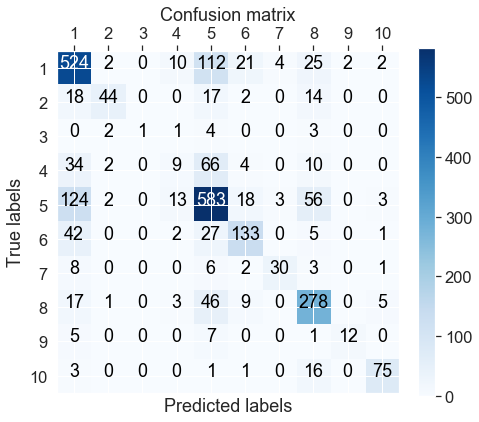

In [20]:
# CLASSIFY ON TEXT WITH REMOVED STOP WORDS
classify(df_topic, text='text', labels='topic', ngram=3, max_df=0.5)

# PART 3. NOUN PHRASE ANALYSIS

## EXTRACT NOUN PHRASES WITH SPACY

In [21]:
# REPEAT THE SAME STEPS AS FOR DF_TOPIC TO ELIMINATE DUPLICATE CONVERSATIONS
df_np = deepcopy(df[['text', 'topic']])
df_np = df_np.drop_duplicates(subset = ['text', 'topic'])
df_np = df_np.drop_duplicates(subset = ['text']).reset_index(drop=True)
print('Conversation after duplicates are removed:', len(df_np))

Conversation after duplicates are removed: 12376


In [30]:
# F(X) TO EXTRACT NOUN PHRASES AND ENTITIES
def extract_nps(text):
    
    tokens = []
    doc = nlp(text)
                    
    # Iterate over base NPs, e.g. "all their good ideas"
    for np in doc.noun_chunks:
                
        # Keep only adjectives and nouns, e.g. "good ideas"
        while len(np) > 1 and np[0].dep_ not in ('amod', 'compound'):
            np = np[1:]
        tokens.append(np.text)
                
    # Iterate over named entities excluding numeric ones
    labels = [u'DATE', u'TIME', u'PERCENT', u'MONEY', u'QUANTITY', u'ORDINAL', u'CARDINAL']
    for ent in doc.ents:
        if ent.label_ not in labels:
            tokens.append(ent.text)
    tokens = ' '.join(tokens)        
    
    # Lemmatize    
    result = []
    doc2 = nlp(tokens)
    for token in doc2:
        result.append(token.lemma_)

    return result

In [31]:
# GET NPs
sw = ['a', 'an', 'the', 'i', 'you', 'he', 'she', 'it', 'we', 'they', 'me', 'him', 'her', '-pron-']
df_np['np'] = df_np['text'].apply(lambda x: extract_nps(x.replace('__eou__', '')))
df_np['np'] = df_np['np'].apply(lambda x: list(set([i.lower() for i in x if i.lower() not in sw and len(i) > 1])))
df_np['np'].tail()

12371    [specific, increase, salary, result, title, mo...
12372    [office, abilitie, pleasure, tipping, confiden...
12373    [london, technician, claim, consignment, fault...
12374    [pin, document, customer, number, atm, maximum...
12375    [average, insurance, partial, need, consignmen...
Name: np, dtype: object

## GET THE MOST FREQUENT NOUN PHRASES AND CONVERSATIONS AROUND THEM

In [35]:
# GET A LIST OF ALL KEYWORDS BASED ON NOUN PHRASES
all_conv = df_np['np'].tolist()
all_conv = [item for sublist in all_conv for item in sublist]
all_conv = [item for item in all_conv if item not in stop_words]

# COUNT OCCURRENCE OF KEYWORDS
c = Counter(all_conv)
frequent_keywords = c.most_common()
frequent_keywords[:20]

[('people', 1023),
 ("'s", 877),
 ('company', 779),
 ('job', 736),
 ('room', 678),
 ('name', 631),
 ('money', 618),
 ('great', 550),
 ('friend', 529),
 ('office', 527),
 ('place', 512),
 ('minute', 489),
 ('big', 476),
 ('business', 463),
 ('hour', 454),
 ('card', 423),
 ('dollar', 406),
 ('food', 399),
 ('school', 394),
 ('price', 369)]

**If I want to see what conversations are about, let's say, 'job':**

In [36]:
def find_me(value, keyword):
        
    if keyword in value:
        return True
    else:
        return False
        
idx = df_np['np'].apply(lambda x: find_me(x, 'job'))
df_subset = df_np[idx][['text', 'np']]
print('Number of conversations about job:', len(df_subset))
df_subset.head(10)

Number of conversations about job: 736


text  \
194   Dad , can you help me ? __eou__ Oh , honey , y...   
261   My goodness ! My silk dress is shrunk . How di...   
311   Oh , my god ! I look so old . I look as if I w...   
581   Sir , I've finished your shaving . Wow , it ta...   
730   Bob , look at this sentence . ' Healthy eating...   
769   Hello , is that Mason's builders ? __eou__ Yes...   
921   Hello , I want to order an Easy-own package . ...   
1551  Do you think chinese families have changed muc...   
1556  Did you watch the finale last night ? My favor...   
1602  Steven , what's the expense of moving house ? ...   

                                                     np  
194              [mistake, answer, good, 's, what, job]  
261   [something, wash, money, water, goodness, silk...  
311   [nose, time, plastic, idea, implant, wrinkle, ...  
581   [try, shave, shop, trend, eyebrow, several, ma...  
730   [nutrient, idea, enough, philosophy, basic, fo...  
769   [anyone, place, ceiling, flood, live, builder,...  
921   [what, call, function, try, package, easy, sho...  
1551  [university, black, retirement, decade, christ...  
1556  [chance, favorite, finale, perseverance, singe...  
1602  [steven, lot, money, shopping, 000, salary, ho...

**This can be repeated for any keyword in frequent_keywords or for all of them in a loop, if needed**

## RUN CLASSIFICATION USING NPs

In [37]:
# CLASSIFY USING ONLY NPs AND THEN USING NPs AS ADDITIONAL FEATURES
print('Shape of data:', df_np.shape)
df_np['np2'] = df_np['np'].apply(lambda x: ' '.join(x))
df_np['np3'] = df_np['text'].apply(lambda x: x.replace('__eou__', '')) + ' ' + df_np['np2']

Shape of data: (12376, 3)


In [38]:
df_np['np3'].head()

0    The kitchen stinks .  I'll throw out the garba...
1    So Dick , how about getting some coffee for to...
2    Are things still going badly with your housegu...
3    Would you mind waiting a while ?  Well , how l...
4    Are you going to the annual party ? I can give...
Name: np3, dtype: object

Share of test set: 0.19998
Train set: (9901, 5)
Test set: (2475, 5)
Average accuracy = 0.68
Classification report:
               precision    recall  f1-score   support

           1       0.68      0.70      0.69       702
           2       0.60      0.55      0.57        95
           3       0.50      0.09      0.15        11
           4       0.28      0.09      0.13       125
           5       0.67      0.71      0.69       802
           6       0.72      0.72      0.72       210
           7       0.76      0.62      0.68        50
           8       0.71      0.82      0.76       359
           9       0.85      0.44      0.58        25
          10       0.85      0.76      0.80        96

   micro avg       0.68      0.68      0.68      2475
   macro avg       0.66      0.55      0.58      2475
weighted avg       0.67      0.68      0.67      2475



<Figure size 432x288 with 0 Axes>

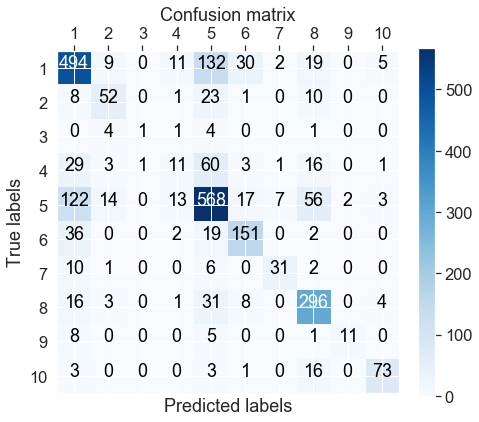

In [40]:
classify(df_np, text='np2', labels='topic', ngram=2, max_df=0.95)

Share of test set: 0.19998
Train set: (9901, 5)
Test set: (2475, 5)
Average accuracy = 0.7
Classification report:
               precision    recall  f1-score   support

           1       0.70      0.76      0.73       702
           2       0.71      0.44      0.55        95
           3       0.50      0.09      0.15        11
           4       0.32      0.05      0.08       125
           5       0.66      0.75      0.71       802
           6       0.81      0.69      0.74       210
           7       0.82      0.64      0.72        50
           8       0.69      0.80      0.74       359
           9       1.00      0.40      0.57        25
          10       0.88      0.61      0.72        96

   micro avg       0.70      0.70      0.70      2475
   macro avg       0.71      0.52      0.57      2475
weighted avg       0.69      0.70      0.68      2475



<Figure size 432x288 with 0 Axes>

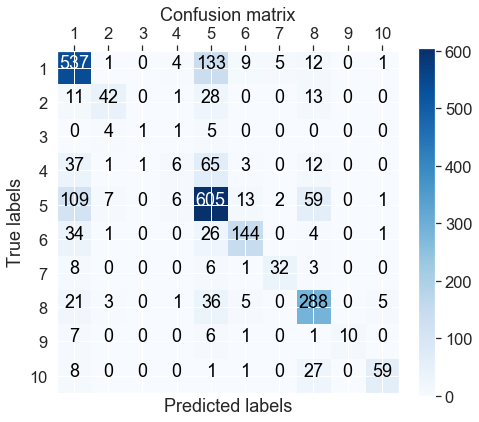

In [41]:
classify(df_np, text='np3', labels='topic', ngram=3, max_df=0.5)

**THE CLASSIFICATION RESULTS ARE VERY CLOSE TO EACH OTHER. A MORE THOROUGH FEATURE GENERATION PROCESS IS PROBABLY NEEDED TO USE NPs MORE EFFICIENTLY**

# PART 4. WORD SENSE DISAMBIGUATION (WSD) USING LESK ALGORITHM

## WSD WITH NLTK LESK

In [44]:
# F(X) FOR WORD SENSE DISAMBIGUATION
def wsd_word(sent, word):
        
    result = ''
    #if wn.synset(word):
    res = lesk(sent, word)         # pos='n' POS
    if res:
        # GET ALL POSSIBLE LEXEMES        
        lemmas = wn.synset(res.name()).lemma_names()
        #hypos = [item.lemma_names() for item in wn.synset(res.name()).hyponyms()]
        #hypers = [item.lemma_names() for item in wn.synset(res.name()).hypernyms()]
        #synonyms = []  
        #for syn in wn.synsets('bank'):
            #for l in syn.lemmas(): 
                #synonyms.append(l.name())                   
       # synonyms = [item.replace('_', ' ') for item in list(set(synonyms))]

        # COMBINE ALL / SOME LEXEMES
        #result = lemmas + hypos + hypers + synonyms
        #result = list(map(str, result))
        #result = [item.replace('[', '').replace(']', '').replace(',', '').replace("'", '').replace('_', '') for item in result]
        result = ' '.join(lemmas)

    return result

def wsd_sent(row):
    
    final_result = ''    
    sentence = row['text'].replace('__eou__', '')
    for w in row['np']:
        final_result = final_result + ' ' + wsd_word(sentence, w)
                
    return final_result.replace('_', '')

In [45]:
df_np['wsd'] = df_np.apply(lambda x: wsd_sent(x), axis=1)
df_np[['text', 'wsd']].head(20)

text  \
0   The kitchen stinks . __eou__ I'll throw out th...   
1   So Dick , how about getting some coffee for to...   
2   Are things still going badly with your housegu...   
3   Would you mind waiting a while ? __eou__ Well ...   
4   Are you going to the annual party ? I can give...   
5   Isn ’ t he the best instructor ? I think he ’ ...   
6   Can I take your order now or do you still want...   
7   Can you manage chopsticks ? __eou__ Why not ? ...   
8   I'm exhausted . __eou__ Okay , let's go home ....   
9   Good evening . Welcome to Cherry's . Do you ha...   
10  What kind of food do you like ? __eou__ I like...   
11  Would you like to take a look at the menu , si...   
12  Can I help you sir , what do you need ? __eou_...   
13  Could I have my bill , please ? __eou__ Certai...   
14  May I sit here ? __eou__ By all means . __eou__\n   
15  Is everything to your satisfaction ? __eou__ N...   
16  I'm looking for a white purse as a gift . Coul...   
17  Dahua's Market . How can I help you ? __eou__ ...   
18  Farmer's Pet Store . __eou__ Can you please te...   
19  May I help you find something , sir ? __eou__ ...   

                                                  wsd  
0                                     kitchen garbage  
1    coffeebean coffeeberry coffee stuff thing cig...  
2    houseguest houseguest college live shrub bush...  
3                       table while piece spell patch  
4    annual yearly yearbook thank givethanks party...  
5    pain painintheneck nuisance comfortable comfy...  
6     little shrimp steak spaghetti girlfriend gir...  
7    custom tradition mastery subordination Chines...  
8                                                      
9    kid kidskin table reservation red reddish rud...  
10   restaurant eatinghouse eatingplace eatery Uni...  
11   spirit tone feel feeling flavor flavour look ...  
12   cigarette cigaret coffinnail butt fag trouble...  
13   mistake error fault worry trouble thing poste...  
14                                               mean  
15    theater theatre house marketplace marketplac...  
16   purse cargo lading freight load loading paylo...  
17   Nanjing Nanking road marketplace marketplace ...  
18   road whistle sing positronemissiontomography ...  
19   vitaminC C ascorbicacid size rhombus rhomb di...

## RUN CLASSIFICATION USING NLTK LESK WSD RESULTS

In [47]:
# CLASSIFY ON WSD RESULTS ONLY AND USING WSD RESULTS AS ADDITIONAL FEATURES WITH TEXT
print('Shape of data:', df_np.shape)
df_np['wsd2'] = df_np['text'].apply(lambda x: x.replace('__eou__', '')) + ' ' + df_np['wsd']

Shape of data: (12376, 7)


Share of test set: 0.19998
Train set: (9901, 7)
Test set: (2475, 7)
Average accuracy = 0.67
Classification report:
               precision    recall  f1-score   support

           1       0.69      0.72      0.71       702
           2       0.68      0.49      0.57        95
           3       0.00      0.00      0.00        11
           4       0.24      0.05      0.08       125
           5       0.67      0.73      0.70       802
           6       0.70      0.62      0.66       210
           7       0.60      0.60      0.60        50
           8       0.62      0.77      0.69       359
           9       0.77      0.40      0.53        25
          10       0.73      0.64      0.68        96

   micro avg       0.67      0.67      0.67      2475
   macro avg       0.57      0.50      0.52      2475
weighted avg       0.65      0.67      0.65      2475



<Figure size 432x288 with 0 Axes>

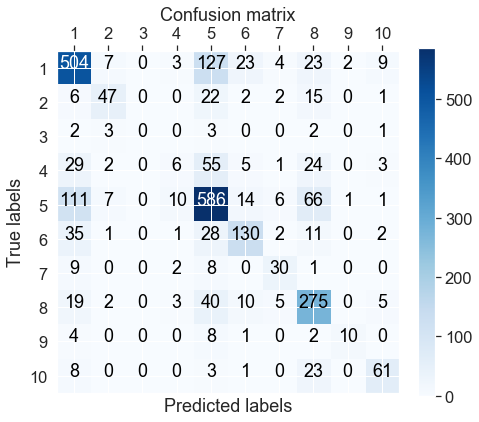

In [51]:
classify(df_np, text='wsd', labels='topic', ngram=1, max_df=0.25)

Share of test set: 0.19998
Train set: (9901, 7)
Test set: (2475, 7)
Average accuracy = 0.69
Classification report:
               precision    recall  f1-score   support

           1       0.71      0.76      0.73       702
           2       0.72      0.40      0.51        95
           3       0.00      0.00      0.00        11
           4       0.25      0.02      0.04       125
           5       0.66      0.77      0.71       802
           6       0.77      0.59      0.67       210
           7       0.72      0.56      0.63        50
           8       0.65      0.80      0.71       359
           9       1.00      0.44      0.61        25
          10       0.88      0.60      0.72        96

   micro avg       0.69      0.69      0.69      2475
   macro avg       0.63      0.49      0.53      2475
weighted avg       0.67      0.69      0.67      2475



<Figure size 432x288 with 0 Axes>

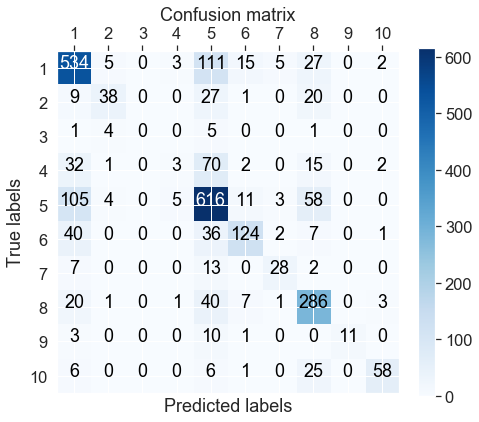

In [52]:
classify(df_np, text='wsd2', labels='topic', ngram=2, max_df=1.0)

**NEXT STEPS:**

**1. BETTER FEATURE GENERATION E.G. IDENTIFYING KEYWORDS ASSOCIATED WITH EACH CATEGORY (AND REMOVING THEM FOR OTHER CATEGORIES?) TO ENABLE THE CLASSIFIER TO PERFORM BETTER;**

**2. USING SENSE2VEC FOR A BETTER WORD SENSE DISAMBIGUATION;**

**3. APPLYING A DEEP LEARNING MODEL E.G. LSTM TO IMPROVE CLASSIFICATION AND WORD SENSE DISAMBIGUATION;**

**4. INTRODUCING RULES TO DISAMBIGUATE WORDS AND CATEGORIES (E.G. WITH SPACY); EXAMPLE: IF CONCEPTS A AND B ARE FOUND, ADD CATEGORY 2 (AS CONTEXT) ETC. - THIS WOULD BE A HYBRID APPROACH WHICH OFTEN WORKS THE BEST;**

**5. IN THE CONTEXT OF AN UNFOLDING CONVERSATION I WOULD, FOR EXAMPLE, USE CALLS TO A TRAINED MODEL API BECAUSE THEY ARE FAST WITH SOME LIGHT APPLICATION OF DISAMBIGUATION RULES - A LIGHT HYBRID APPROACH THAT WOULD ENABLE THE REQUIRED SPEED**